In [72]:
# Master jupyter notebook for Case Study

In [73]:
# importing libraries
import pandas as pd
import sqlite3
from sklearn.preprocessing import LabelEncoder
import datetime
from forex_python.converter import CurrencyRates
from forex_python.converter import RatesNotAvailableError
import plotly.express as px
import nbformat
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [74]:
# extracting tables from database
def list_tables(database_file):
    connection = sqlite3.connect('data.db')
    cursor = connection.cursor()
    cursor.execute("""select name from sqlite_master where type = 'table';
                    """)
                    
    tables = cursor.fetchall()
    cursor.close()
    connection.close()
    table_names = [table[0] for table in tables]
    return table_names

# saving tables as dataframes
connection = sqlite3.connect('data.db')
query = """select *
        from client as cl;
        """
client = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from client_products as cl;
        """
client_products = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from balances as cl;
        """
balances = pd.read_sql_query(query, connection)
connection.close

connection = sqlite3.connect('data.db')
query = """select *
        from inv_campaign_eval as cl;
        """
inv_campaign_eval = pd.read_sql_query(query, connection)
connection.close

# merging tables with client data (excluding balances and campaign eval table)
connection = sqlite3.connect('data.db')
query = """
        select cl.client_id, age, job, marital, education, gender, has_deposits, loan, has_insurance, has_mortgage
        from client as cl
        left join client_products as cp on cl.client_id = cp.client_id
        --left join balances as ba on cl.client_id = ba.client_id
        --left join inv_campaign_eval as camp on cl.client_id = camp.client_id;
        """
clients_merged = pd.read_sql_query(query, connection)
connection.close

<function Connection.close>

In [75]:
# checking for datatypes
print(clients_merged.dtypes)

# checking for missing values
print(client.isnull().sum()) # missing values in Age and Job
print(client_products.isnull().sum()) # no missing values
print(inv_campaign_eval.isnull().sum()) # no missing values
print(balances.isnull().sum()) # no missing values

# dealing with missing values
clients_merged['job'].fillna('unknown', inplace=True) # imputing "unknown" in job
clients_merged['age'].fillna(clients_merged['age'].median(), inplace=True) # imputing median in age

client_id          int64
age              float64
job               object
marital           object
education         object
gender            object
has_deposits      object
loan              object
has_insurance     object
has_mortgage      object
dtype: object
client_id      0
age          232
job          438
marital        0
education      0
gender         0
dtype: int64
client_id        0
has_deposits     0
loan             0
has_insurance    0
has_mortgage     0
dtype: int64
client_id    0
poutcome     0
dtype: int64
date         0
balance      0
client_id    0
currency     0
dtype: int64


In [76]:
# label encoding categorical variables
le = LabelEncoder()
clients_merged['has_deposits_enc'] = le.fit_transform(clients_merged['has_deposits'])
clients_merged['loan_enc'] = le.fit_transform(clients_merged['loan'])
clients_merged['has_insurance_enc'] = le.fit_transform(clients_merged['has_insurance'])
clients_merged['has_mortgage_enc'] = le.fit_transform(clients_merged['has_mortgage'])
clients_merged['marital_enc'] = le.fit_transform(clients_merged['marital'])
clients_merged['education_enc'] = le.fit_transform(clients_merged['education'])
clients_merged['gender_enc'] = le.fit_transform(clients_merged['gender'])
clients_merged['job_enc'] = le.fit_transform(clients_merged['job'])

In [77]:
# extracting encoding labels for future reference
job_labels = clients_merged[['job', 'job_enc']].drop_duplicates().sort_values('job_enc')
gender_labels = clients_merged[['gender', 'gender_enc']].drop_duplicates().sort_values('gender_enc')
education_labels = clients_merged[['education', 'education_enc']].drop_duplicates().sort_values('education_enc')
marital_labels = clients_merged[['marital', 'marital_enc']].drop_duplicates().sort_values('marital_enc')
has_mortgage_labels = clients_merged[['has_mortgage', 'has_mortgage_enc']].drop_duplicates().sort_values('has_mortgage_enc')
has_insurance_labels = clients_merged[['has_insurance', 'has_insurance_enc']].drop_duplicates().sort_values('has_insurance_enc')
loan_labels = clients_merged[['loan', 'loan_enc']].drop_duplicates().sort_values('loan_enc')
has_deposits_labels = clients_merged[['has_deposits', 'has_deposits_enc']].drop_duplicates().sort_values('has_deposits_enc')

In [78]:
# editing table balances
# removing time from datetime
balances['date'] = pd.to_datetime(balances['date'])
balances['date'] = balances['date'].dt.date

# fetching currency exchange rates for EUR and USD
c = CurrencyRates()

dates = balances['date'].drop_duplicates()
target_currency = 'CZK'

# EUR
base_currency = 'EUR'

eur_rates_date = []
eur_rates_rate = []

for date in dates:
    rate = c.get_rate(base_currency, target_currency, date)
    eur_rates_date.append(date)
    eur_rates_rate.append(rate)

eur_df = pd.DataFrame({'date': eur_rates_date, 'eur_rate': eur_rates_rate})

# USD
base_currency = 'USD'

usd_rates_date = []
usd_rates_rate = []

for date in dates:
    rate = c.get_rate(base_currency, target_currency, date)
    usd_rates_date.append(date)
    usd_rates_rate.append(rate)

usd_df = pd.DataFrame({'date': usd_rates_date, 'usd_rate': usd_rates_rate})

# mapping exchange rate columns into balances dataframe
balances = pd.merge(balances, eur_df, on = 'date')
balances = pd.merge(balances, usd_df, on = 'date')



In [79]:
# creating column with balances recalculated to czk
for index, row in balances.iterrows():
    if row['currency'] == 'EUR':
        balances.at[index, 'fx_rate'] = balances.at[index, 'eur_rate']
    elif row['currency'] == 'USD':
        balances.at[index, 'fx_rate'] = balances.at[index, 'usd_rate']
    else:
        balances.at[index, 'fx_rate'] = 1

balances['balance_in_czk'] = balances['balance']*balances['fx_rate']

In [80]:
# table balances: editing and feature engineering from variables: balance, currency
# encoding outcome variable 
inv_campaign_eval['poutcome_enc'] = le.fit_transform(inv_campaign_eval['poutcome'])

# last balance
last_timestamp_index = balances.groupby('client_id')['date'].idxmax()
last_timestamp_df = balances.loc[last_timestamp_index]
last_timestamp_df.rename(columns={'balance_in_czk': 'last_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, last_timestamp_df[['last_balance','client_id']], on = 'client_id')

# mean balance
mean_bal_by_client = balances.groupby('client_id')['balance_in_czk'].mean().reset_index()
mean_bal_by_client.rename(columns={'balance_in_czk': 'mean_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, mean_bal_by_client[['mean_balance','client_id']], on = 'client_id')

# min balance
min_bal_by_client = balances.groupby('client_id')['balance_in_czk'].min().reset_index()
min_bal_by_client.rename(columns={'balance_in_czk': 'min_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, min_bal_by_client[['min_balance','client_id']], on = 'client_id')

# max balance
max_bal_by_client = balances.groupby('client_id')['balance_in_czk'].max().reset_index()
max_bal_by_client.rename(columns={'balance_in_czk': 'max_balance'}, inplace=True)
clients_merged = pd.merge(clients_merged, max_bal_by_client[['max_balance','client_id']], on = 'client_id')

# currency (encoded)
clients_merged = pd.merge(clients_merged, balances[['client_id','currency']].drop_duplicates(), on = 'client_id')
clients_merged['currency_enc'] = le.fit_transform(clients_merged['currency'])
currency_labels = clients_merged[['currency', 'currency_enc']].drop_duplicates().sort_values('currency_enc')

In [81]:
# creating table first round of campaign - original columns (for visualizations)
first_round_vis = clients_merged[['client_id', 'age', 'job', 'marital', 'education', 'gender','has_deposits', 'loan', 'has_insurance', 'has_mortgage', 'last_balance','mean_balance', 'min_balance', 'max_balance', 'currency']]
first_round_vis = pd.merge(inv_campaign_eval[['client_id','poutcome']], first_round_vis, on = 'client_id')
first_round_vis['age'] = first_round_vis['age'].astype(int)

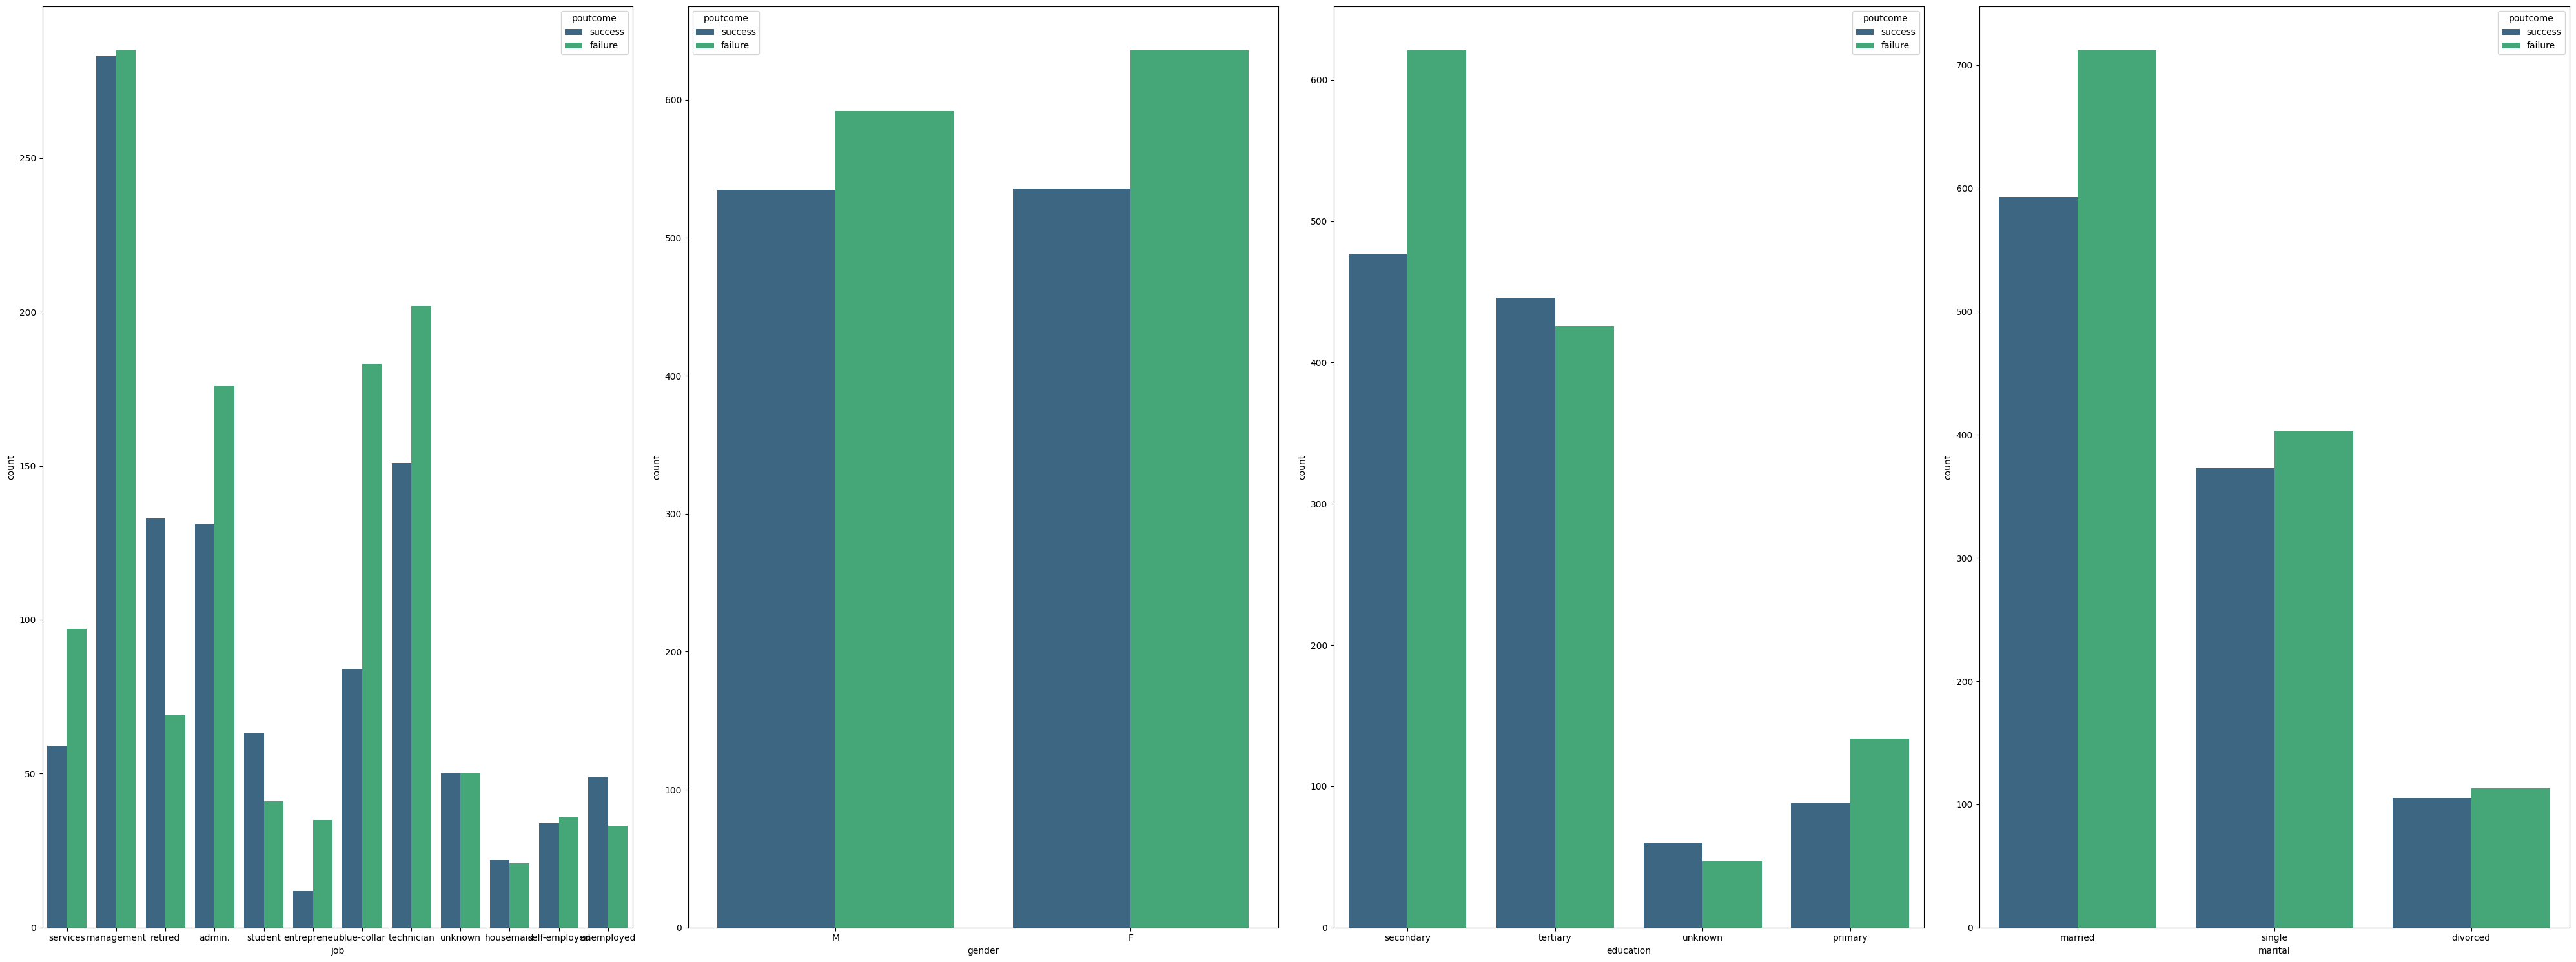

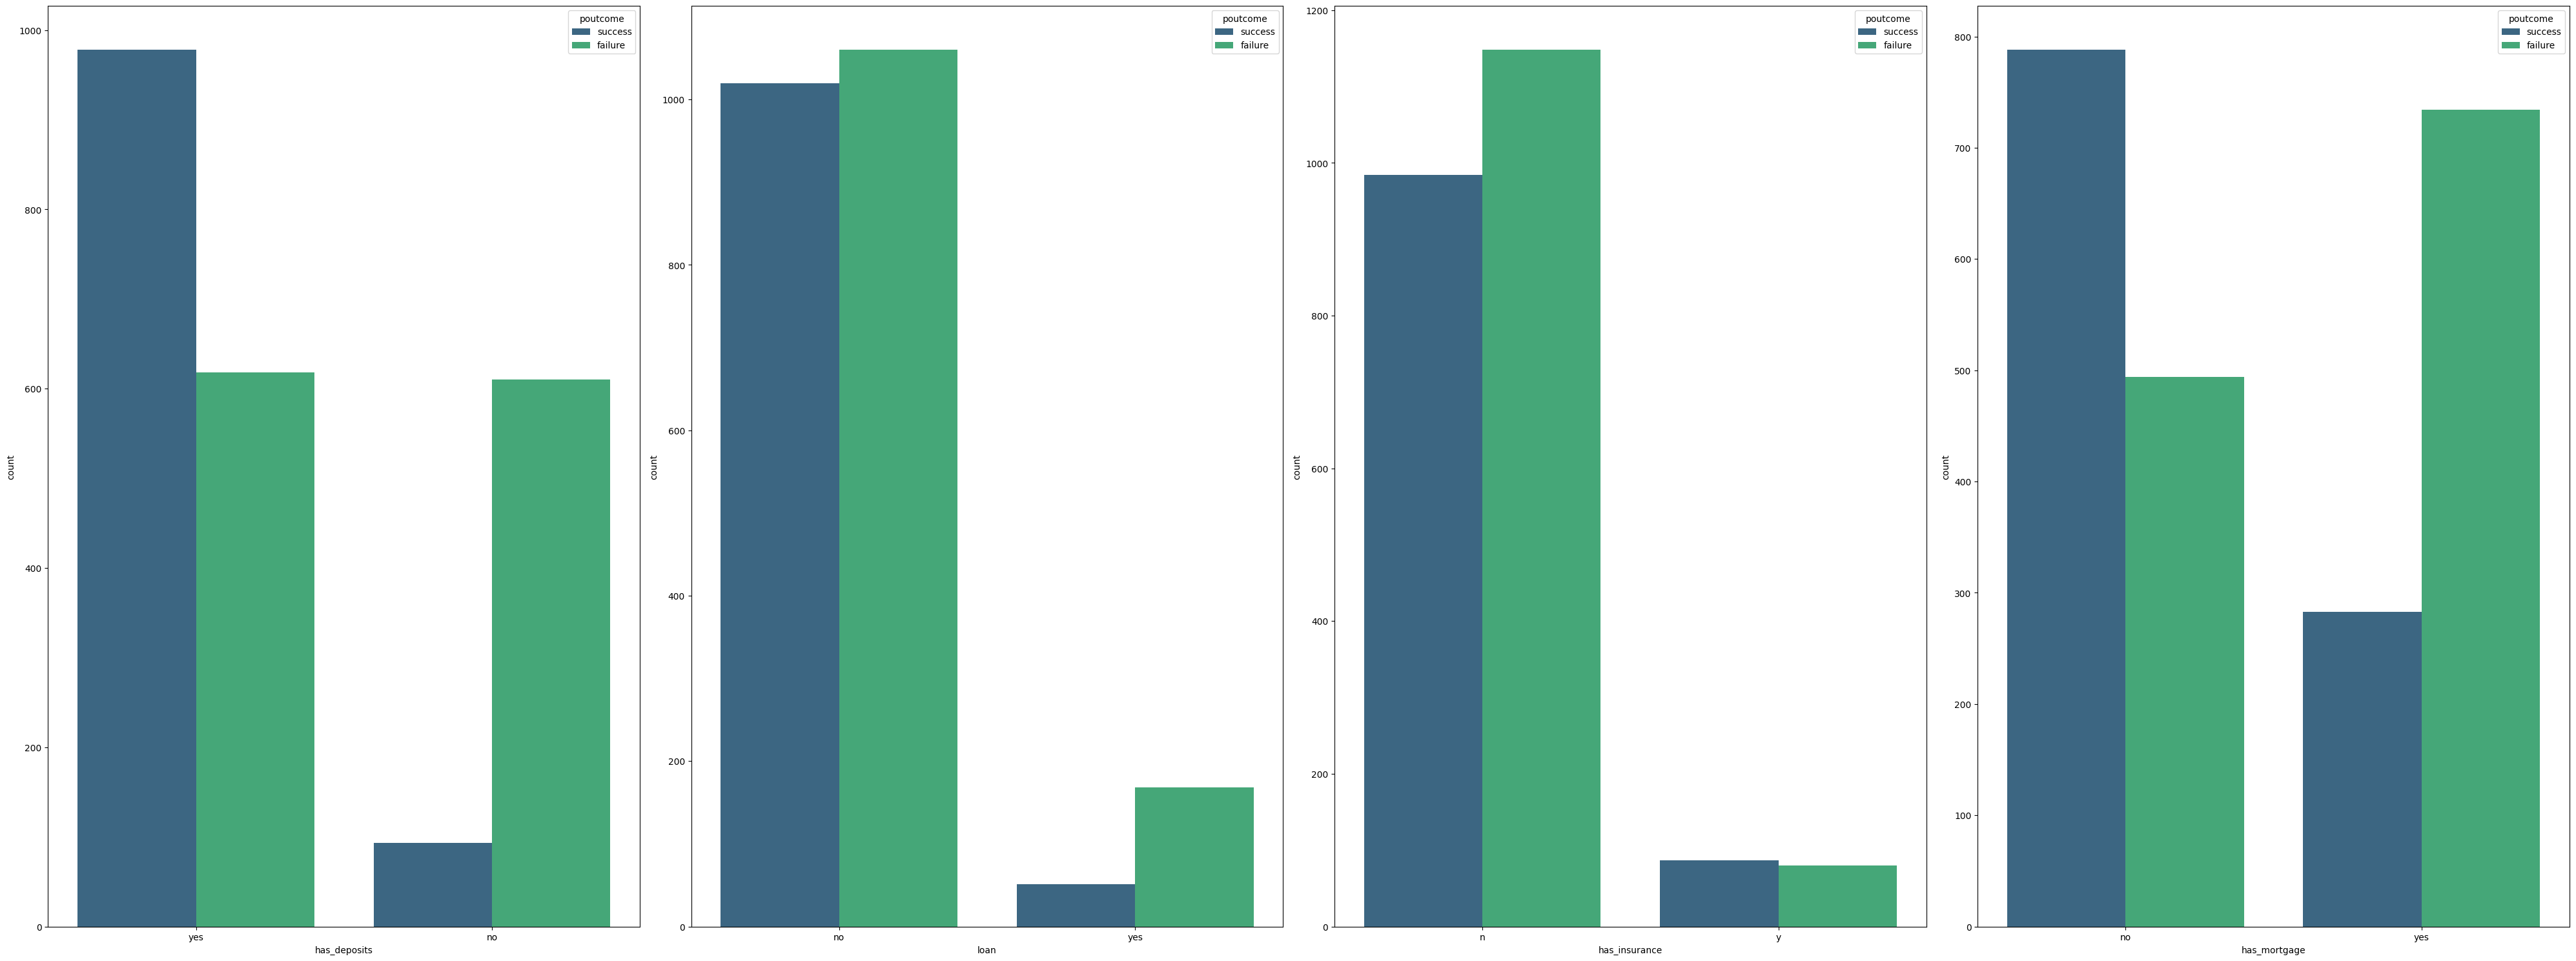

In [82]:
# visualizations of data from first round of campaign
# TO DO

plt.figure(figsize=(40, 15))

plt.subplot(1, 4, 1)
sns.countplot(x='job', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 2)
sns.countplot(x='gender', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 3)
sns.countplot(x='education', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 4)
sns.countplot(x='marital', hue='poutcome', data=first_round_vis, palette='viridis')

plt.tight_layout()
plt.show()
# ------------------------------------------------------------------------------------------
plt.figure(figsize=(40, 15))

plt.subplot(1, 4, 1)
sns.countplot(x='has_deposits', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 2)
sns.countplot(x='loan', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 3)
sns.countplot(x='has_insurance', hue='poutcome', data=first_round_vis, palette='viridis')

plt.subplot(1, 4, 4)
sns.countplot(x='has_mortgage', hue='poutcome', data=first_round_vis, palette='viridis')

plt.tight_layout()
plt.show()

In [83]:
# creating table first round of campaign - encoded columns (for modeling)
first_round_clients = clients_merged[['client_id', 'age', 'has_deposits_enc', 'loan_enc', 'has_insurance_enc', 'has_mortgage_enc','marital_enc', 'education_enc', 'gender_enc', 'job_enc', 'last_balance','mean_balance', 'min_balance', 'max_balance', 'currency_enc']]
first_round_clients = pd.merge(inv_campaign_eval[['client_id','poutcome_enc']], first_round_clients, on = 'client_id')
first_round_clients['age'] = first_round_clients['age'].astype(int)

In [84]:
# creating X-matrix of predictors and y-outcome variable
X = first_round_clients.drop(['client_id','poutcome_enc'], axis = 1)
y = first_round_clients['poutcome_enc']

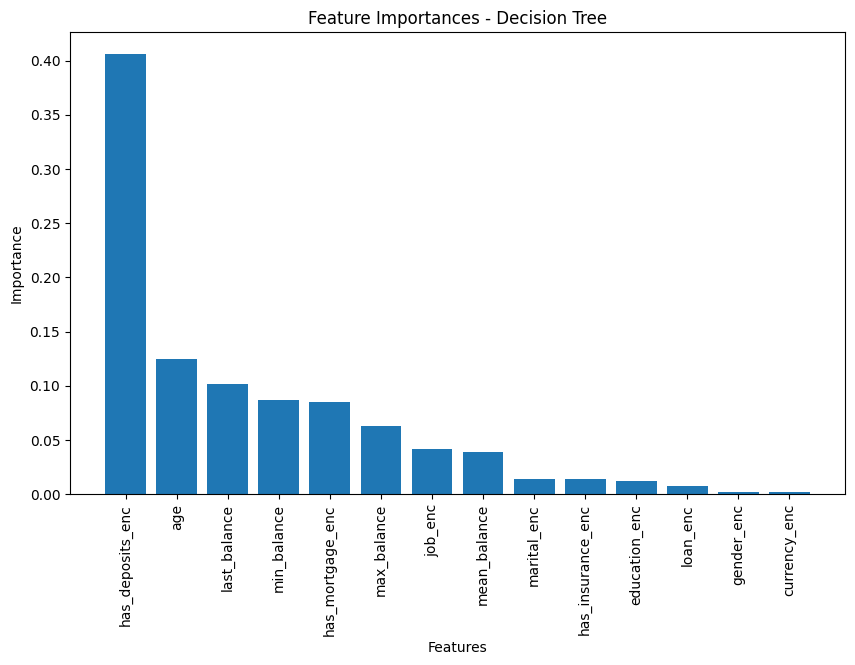

In [85]:
# selecting most important features from X using feature importance
classifier = DecisionTreeClassifier(max_depth=10, min_samples_split=4)

classifier.fit(X, y)
importances = classifier.feature_importances_
feature_names = ['age', 'has_deposits_enc', 'loan_enc', 'has_insurance_enc', 'has_mortgage_enc',
                     'marital_enc', 'education_enc', 'gender_enc', 'job_enc', 'last_balance',
                     'mean_balance', 'min_balance', 'max_balance', 'currency_enc']

sorted_data = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse = True)
sorted_feature_names, sorted_importances = zip(*sorted_data)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances - Decision Tree')
plt.bar(sorted_feature_names, sorted_importances, align="center")
plt.xticks(sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# based on decision tree and feature importances, we consider as most important these variables:
# 'has_deposits_enc', 'age', 'last_balance','min_balance', 'has_mortgage_enc','max_balance','mean_balance','job_enc'
X = X[['has_deposits_enc', 'age', 'last_balance','min_balance', 'has_mortgage_enc','max_balance','mean_balance','job_enc']]

In [86]:
# performing train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [114]:
# Logistic Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the Logistic Regression model
logistic_classifier = LogisticRegression()

# Define the hyperparameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga']
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=logistic_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_sc, y_train)

# Get the best hyperparameters
best_lr_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_lr_params}")

# Train the model with the best hyperparameters on the full training set
best_logistic_classifier = LogisticRegression(max_iter=1000, **best_lr_params)
best_logistic_classifier.fit(X_train_sc, y_train)

# Predictions on the test set
y_pred = best_logistic_classifier.predict(X_test_sc)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Best Hyperparameters: {accuracy}")

/Users/zuzana/case_study/case_study/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zuzana/case_study/case_study/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zuzana/case_study/case_study/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zuzana/case_study/case_study/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zuzana/case_study/case_study/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy with Best Hyperparameters: 0.7


/Users/zuzana/case_study/case_study/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zuzana/case_study/case_study/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zuzana/case_study/case_study/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zuzana/case_study/case_study/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zuzana/case_study/case_study/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

In [113]:
# KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define the KNN classifier
knn_classifier = KNeighborsClassifier()

# Define the hyperparameter grid to search over
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_sc, y_train)

# Get the best hyperparameters
best_knn_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_knn_params}")

# Train the model with the best hyperparameters on the full training set
best_knn_classifier = KNeighborsClassifier(**best_knn_params)
best_knn_classifier.fit(X_train_sc, y_train)

# Predictions on the test set
y_pred = best_knn_classifier.predict(X_test_sc)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Best Hyperparameters: {accuracy}")

Best Hyperparameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Test Accuracy with Best Hyperparameters: 0.6695652173913044


In [111]:
# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

rf_classifier = RandomForestClassifier()

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_sc, y_train)

# Get the best hyperparameters
best_rf_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_rf_params}")

# Train the model with the best hyperparameters on the full training set
best_rf_classifier = RandomForestClassifier(**best_rf_params)
best_rf_classifier.fit(X_train_sc, y_train)

# Predictions on the test set
y_pred = best_rf_classifier.predict(X_test_sc)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Best Hyperparameters: {accuracy}")



Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Test Accuracy with Best Hyperparameters: 0.6927536231884058


In [90]:
# Adaboost

In [91]:
# Neural Network


Random Forest Metrics:
F1 Score: 0.7132262051915946
AUC-ROC: 0.7669539908900224
AUC-PR: 0.6768208177827358

Logistic Regression Metrics:
F1 Score: 0.6943894389438944
AUC-ROC: 0.76989704732472
AUC-PR: 0.6812446777045744

KNN Metrics:
F1 Score: 0.6842435655994978
AUC-ROC: 0.7502916682180933
AUC-PR: 0.6708195291178031


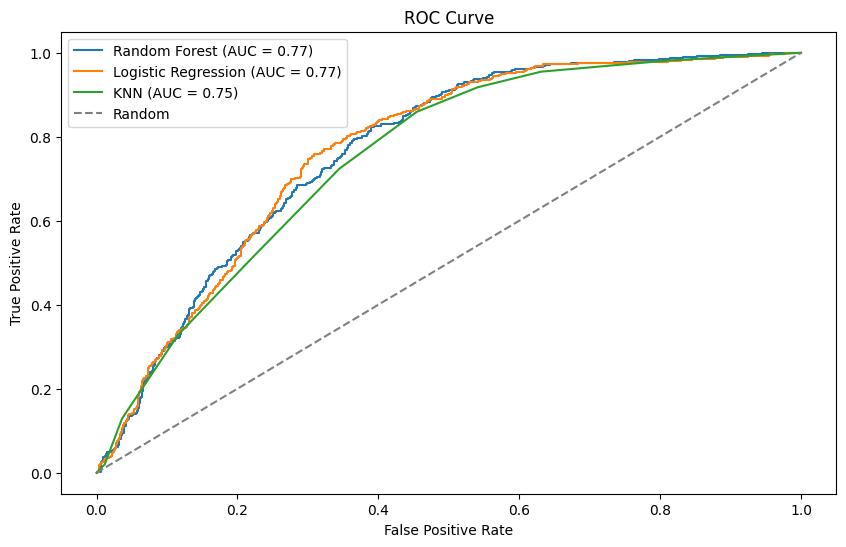

In [115]:
# run on Test data - compare models on F1, AUC - choose best model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.model_selection import cross_val_predict

# Define models
rf_classifier = RandomForestClassifier(**best_rf_params)  # Replace with your best hyperparameters
logistic_classifier = LogisticRegression(**best_lr_params)  # Replace with your best hyperparameters
knn_classifier = KNeighborsClassifier(**best_knn_params)  # Replace with your best hyperparameters

classifiers = [rf_classifier, logistic_classifier, knn_classifier]
classifier_names = ['Random Forest', 'Logistic Regression', 'KNN']

# Define metrics
metrics = {'F1 Score': f1_score, 'AUC-ROC': roc_auc_score}

# Collect results
results = {}

for classifier, name in zip(classifiers, classifier_names):
    # F1 Score
    y_pred = cross_val_predict(classifier, X_train_sc, y_train, cv=5)
    f1 = f1_score(y_train, y_pred)
    
    # AUC-ROC
    y_scores = cross_val_predict(classifier, X_train_sc, y_train, cv=5, method="predict_proba")[:, 1]
    roc_auc = roc_auc_score(y_train, y_scores)
    
    # AUC-PR
    precision, recall, _ = precision_recall_curve(y_train, y_scores)
    pr_auc = auc(recall, precision)
    
    results[name] = {'F1 Score': f1, 'AUC-ROC': roc_auc, 'AUC-PR': pr_auc}

# Print results
for name, metrics_dict in results.items():
    print(f"\n{name} Metrics:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")

# ROC Curve
plt.figure(figsize=(10, 6))
for classifier, name in zip(classifiers, classifier_names):
    y_scores = cross_val_predict(classifier, X_train_sc, y_train, cv=5, method="predict_proba")[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['AUC-ROC']:.2f})")

plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [93]:
# editing data of clients not included in first run
# Second_round_clients poutcome_enc
not_in_first_round = first_round_clients[['client_id','poutcome_enc']]
merged_df = pd.merge(not_in_first_round, clients_merged, on='client_id', how='outer', indicator=True, suffixes=('', ' '))

# # Select rows where 'client_id' is not present in 'first_round_clients'
merged_df = merged_df[merged_df['_merge'] == 'right_only']

# Drop the '_merge' column (optional)
not_in_first_round = merged_df.drop('_merge', axis=1)
not_in_first_round = not_in_first_round[['client_id','poutcome_enc', 'age', 'has_deposits_enc', 'loan_enc', 'has_insurance_enc', 'has_mortgage_enc','marital_enc', 'education_enc', 'gender_enc', 'job_enc', 'last_balance','mean_balance', 'min_balance', 'max_balance', 'currency_enc']]
# Display the result
not_in_first_round

,client_id,poutcome_enc,age,has_deposits_enc,loan_enc,has_insurance_enc,has_mortgage_enc,marital_enc,education_enc,gender_enc,job_enc,last_balance,mean_balance,min_balance,max_balance,currency_enc
2299,1222646323,NaN,46.0,0,0,0,0,0,3,1,7,1005.302876,960.562073,886.126906,1054.517907,0
2300,451375919,NaN,33.0,0,0,0,1,2,1,0,0,1100.917203,1221.016419,1100.917203,1303.494818,0
2301,338972671,NaN,44.0,0,0,1,1,1,1,0,6,357.676547,297.993265,202.053088,446.676191,0
2302,1472834688,NaN,36.0,1,0,0,1,1,0,1,1,1906.382731,1919.318145,1853.387429,2011.939205,0
2303,1068680340,NaN,63.0,1,0,0,1,1,1,0,0,27.197528,0.972130,-104.261740,77.806737,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,440873221,NaN,56.0,0,0,0,0,0,2,0,4,412.546184,386.995526,270.665696,469.647273,0
11158,543198889,NaN,40.0,0,0,0,1,2,3,1,1,5.538113,18.441905,-98.265981,125.568092,0
11159,458558558,NaN,41.0,0,0,0,1,0,0,0,3,70.463701,25.552707,-117.991255,116.816943,0
11160,1426334329,NaN,59.0,0,0,1,1,1,0,0,9,3232.008038,3157.720202,3024.384824,3263.371390,0


In [94]:
# run best model on data not included in first run - output predict_proba - select 3000 ids